In [1]:
import torch
import warnings
import os
import wandb

warnings.simplefilter("ignore", UserWarning)

import numpy as np

from dataset.data_loaders import dataset_for_deepar
from pytorch_forecasting import DeepAR

from pytorch_forecasting.metrics import NormalDistributionLoss
from inference.bayesian.utils import plot_forecast
from inference.inference import inference

c:\Users\mgphy\Anaconda3\envs\uncertainty_pf\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
config = {
            "dataset": "acea",
            "inference": "deepar",
            "batch": 128,
            "encoder": 7,
            "hidden_size": 16,
            "lr": 0.015,
            "rnn_layers": 8,
            "num_iterations": 20,
            "num_samples": 500,
            "sweep": True,
            "plot": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
training, train_dataloader, val_dataloader, test_dataloader, horizon = dataset_for_deepar(config.dataset)

In [4]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [5]:
model = DeepAR.from_dataset(
    training,
    learning_rate=config.lr,
    hidden_size=config.hidden_size,
    rnn_layers=config.rnn_layers,
    loss=NormalDistributionLoss(),
    optimizer="Adam",
)

In [ ]:
predictive, diagnostics = inference(config, model, None,
                                    X_train=train_dataloader, Y_train=None, 
                                    X_val=val_dataloader, Y_val=None,
                                    X_test=test_dataloader, Y_test=None,
                                    quantiles=quantiles,
                                    horizon=horizon,
                                    device=device)

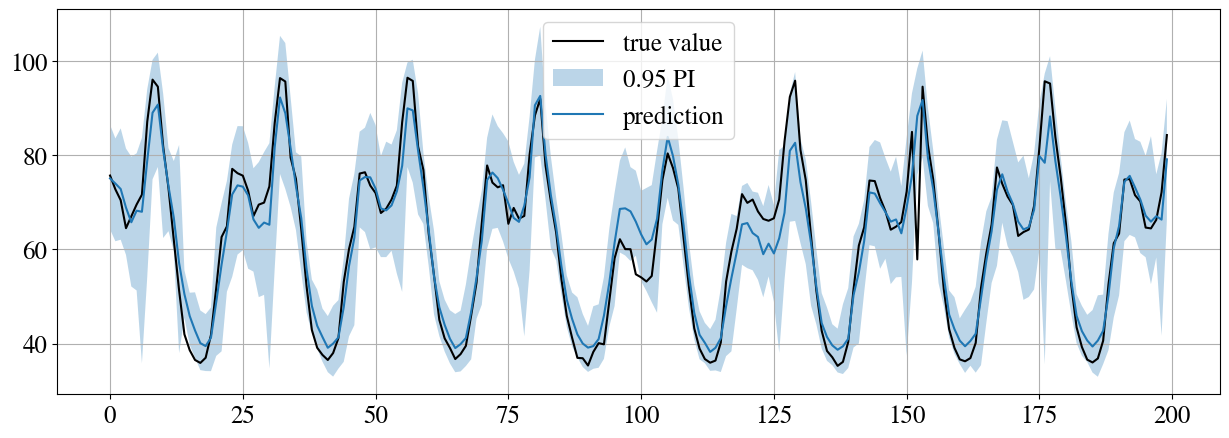

In [8]:
CI = [diagnostics["quantiles"][2], diagnostics["quantiles"][-2]]

plot_forecast(predictive, predictive["y"], None, np.zeros(shape=(predictive['obs'].shape[1])), CI, "deepar", 200)

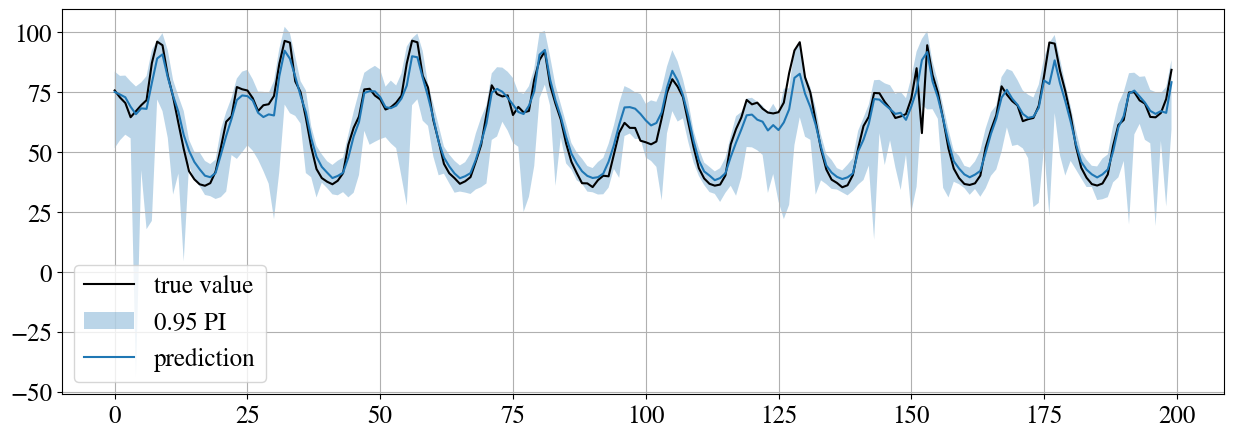

In [9]:
CI = [diagnostics["new_quantiles"][2], diagnostics["new_quantiles"][-2]]

plot_forecast(predictive, predictive["y"], None, np.zeros(shape=(predictive['obs'].shape[1])), CI, "deepar", 200)

In [10]:
for k, v in diagnostics.items():
    print(k, "\t", v)

train_time 	 1020.375
final_loss 	 nan
inference_time 	 98.65625
cal_error 	 0.27759362559551526
new_cal_error 	 0.15907899056229027
quantiles 	 [0, 0.005, 0.025, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35000000000000003, 0.375, 0.4, 0.42500000000000004, 0.45, 0.47500000000000003, 0.5, 0.525, 0.55, 0.5750000000000001, 0.6000000000000001, 0.625, 0.65, 0.675, 0.7000000000000001, 0.7250000000000001, 0.75, 0.775, 0.8, 0.8250000000000001, 0.8500000000000001, 0.875, 0.9, 0.925, 0.9500000000000001, 0.9750000000000001, 0.995]
new_quantiles 	 [0.         0.         0.         0.00131915 0.009      0.01649495
 0.0239899  0.03622378 0.0491958  0.06474576 0.08138614 0.09975248
 0.1205618  0.14280488 0.1688806  0.19220238 0.216      0.23904762
 0.26316901 0.28591398 0.30586022 0.32585227 0.34693182 0.37365672
 0.39885135 0.42034483 0.44246988 0.4664     0.49113333 0.5195082
 0.54640845 0.57685185 0.60945